In [1]:
import numpy as np
import torch
import torch.nn as nn
from models import *
import torchvision
from torchvision import transforms, datasets
from torch.distributions import normal
import matplotlib.pyplot as plt
import captum
from captum.attr import DeepLift, IntegratedGradients, Saliency, NoiseTunnel, GradientShap
from captum.attr import visualization as viz
import argparse
from utils import get_args
import matplotlib
from models.model import *

D:\ProgramData\anaconda\env3\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def attribute_image_features(algorithm, input, **kwargs):
    global_model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )
    return tensor_attributions

def add_gaussian_noise(noise_scale, input):
    noise = torch.randn_like(input) * noise_scale
    return input + noise

def predict_with_randomized_smoothing(noise_scale, model, image, num_samples):
    # Expand the single image to a batch
    image_batch = image.repeat(num_samples, 1, 1, 1)
    # Add Gaussian noise
    noisy_images = add_gaussian_noise(noise_scale, image_batch)

    # Predict using the model
    predictions = model(noisy_images)

    # Get the predicted classes for each noisy image
    _, predicted_classes = predictions.max(1)
    #Result
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    # Return the most frequently predicted class
    return avg_noisy_image, predictions, predicted_classes, prediction

def show_image(input, noise_scale):
    fig, axes = plt.subplots(1, len(noise_scale), figsize=(20, 10))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for idx, noise in enumerate(noise_scale):
        avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise, global_model, input, 100)
        print(f'Noise: {noise}, Ground Truth: {ground_truth_prediction}, Noised Result: {prediction}')
        img = avg_noisy_image.squeeze().cpu().detach().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        ax = axes[idx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'noise_scale:{noise}')
    plt.tight_layout()
    plt.show()

def quantization_visualization(args, sigma, model, input, noise_scale, method="masked_image", sign="positive"):
    avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise_scale, model, input, 100)
    attr_ig, delta = attribute_image_features(ig, avg_noisy_image, baselines=avg_noisy_image * 0, n_steps=1000, return_convergence_delta=True)
    num_escape = int(args.num_escape)
    grad = attr_ig.reshape(attr_ig.shape[0], -1)
    w0 = grad.mean(dim=0)
#     w0 = torch.sum(grad, 0) / grad.size(0)
    des, _ = torch.sort(grad, dim=0, descending=True)
    e11 = des[num_escape:]
    e1 = e11.mean(dim=0)
    e21 = des[:-num_escape]
    e2 = e21.mean(dim=0)
    e = torch.stack((e1, e2), dim=0)
    e = torch.abs(torch.sub(w0, e))
    e, _ = torch.max(e, dim=0)
    milestone = sigma * sigma / 2
    m = normal.Normal(0, sigma * sigma)
    g_x = torch.zeros(w0.shape[0], 3).to(device)
    g_x[:, 0] = 1 - m.cdf(torch.sub(milestone, w0))
    g_x[:, 1] = m.cdf(torch.sub(milestone, w0)) - m.cdf(torch.sub(-milestone, w0))
    g_x[:, 2] = m.cdf(torch.sub(-milestone, w0))
    g_x_p, _ = torch.sort(g_x, dim=1, descending=True)
    g_x_p = g_x_p[:, :2]
    radius = (sigma / 2 * (m.icdf(g_x_p[:, 0]) - m.icdf(g_x_p[:, 1])))
#     print(m.icdf(g_x_p[:, 0]).shape)
#     print(g_x_p[:, 0].shape)
    failed = torch.gt(e, radius)
    g_x[failed == True, 0] = 0.0
    g_x[failed == True, 1] = 1.0
    g_x[failed == True, 2] = 0.0
    v_x = torch.argmax(g_x, dim=1)
    v_x = F.one_hot(v_x, num_classes=3)
    v_x = v_x.float()
    v_x[:, 0] = torch.mul(v_x[:, 0], args.gamma)
    v_x[:, 1] = torch.mul(v_x[:, 1], 0.0)
    v_x[:, 2] = torch.mul(v_x[:, 2], -args.gamma)
    v_x = torch.sum(v_x, dim=1).float()
    v_x = v_x.reshape(grad.shape).to(device)
    grad = v_x
    tensor_28x28 = grad.squeeze().cpu().detach().reshape(28, 28)
    attr_ig = np.transpose(tensor_28x28.detach().numpy(), (1, 0))
    print('-------------------')
    print('Smoothing Image')
    print('Predicted:', classes[prediction],
          ' Probability:', torch.max(F.softmax(predictions, 1)).item())
    attr_ig = attr_ig[:, :, np.newaxis]
    avg_noisy_np = avg_noisy_image.squeeze().unsqueeze(-1).cpu().detach().numpy()
    _ = viz.visualize_image_attr(attr_ig, avg_noisy_np, method=method, sign=sign,
                          show_colorbar=True, title="Overlayed Integrated Gradients")
#     print(radius)

Noise: 0, Ground Truth: 6, Noised Result: 6
Noise: 0.5, Ground Truth: 6, Noised Result: 6
Noise: 1, Ground Truth: 6, Noised Result: 6
Noise: 1.5, Ground Truth: 6, Noised Result: 6
Noise: 2.0, Ground Truth: 6, Noised Result: 5
Noise: 2.5, Ground Truth: 6, Noised Result: 5
Noise: 3.0, Ground Truth: 6, Noised Result: 5
Noise: 3.5, Ground Truth: 6, Noised Result: 5
Noise: 4.0, Ground Truth: 6, Noised Result: 5
Noise: 4.5, Ground Truth: 6, Noised Result: 5
Noise: 5.0, Ground Truth: 6, Noised Result: 5


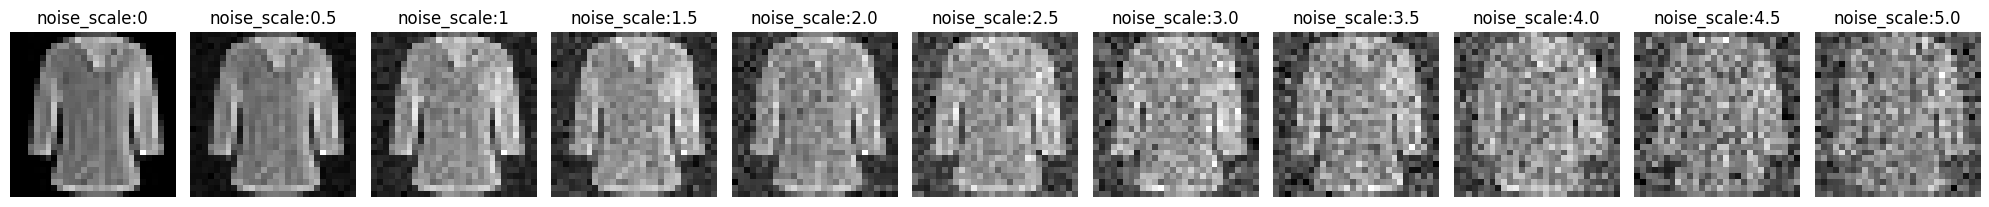

In [59]:
args = get_args.get_arg()
data_dir = './data/fashion'
sigma = 0.5
apply_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(data_dir, train=True, download=True, transform=apply_transform)
test_dataset = datasets.FashionMNIST(data_dir, train=False, download=True, transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)
device = 'cuda'
global_model = CNNFashion()
global_model.load_state_dict(torch.load(f'./checkpoints/fashion/{sigma}/best_model_fashion.pth'))
global_model.to(device)
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
ind = 4
input = images[ind].unsqueeze(0)
input.requires_grad = True
global_model.eval()
ground_truth_predictions = global_model(input)
_, predicted_classes = ground_truth_predictions.max(1)
ground_truth_prediction = torch.bincount(predicted_classes).argmax().item()
noise_scale = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0 ,3.5, 4.0, 4.5, 5.0]
show_image(input, noise_scale)

-------------------
Original Image
Predicted: Shirt  Probability: 0.6705156564712524
-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.67323899269104


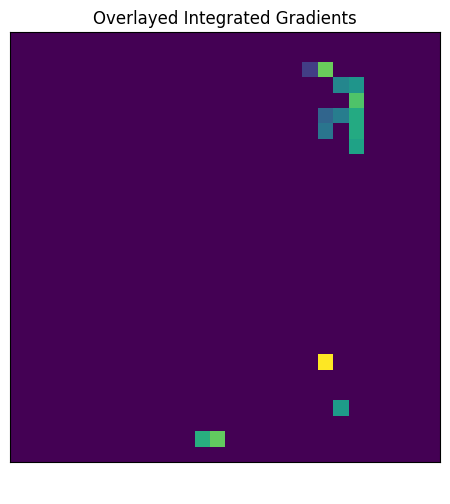

In [60]:
saliency = Saliency(global_model)
ig = IntegratedGradients(global_model)
dl = DeepLift(global_model)
nt = NoiseTunnel(ig)
print('-------------------')
print('Original Image')
print('Predicted:', classes[predicted_classes],
      ' Probability:', torch.max(F.softmax(ground_truth_predictions, 1)).item())
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.001,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.6999359130859375


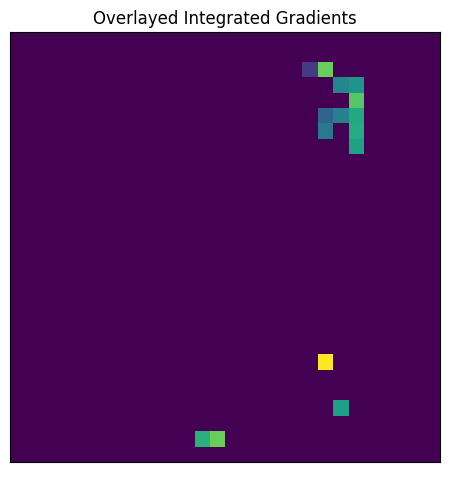

In [61]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.01,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.8846127986907959


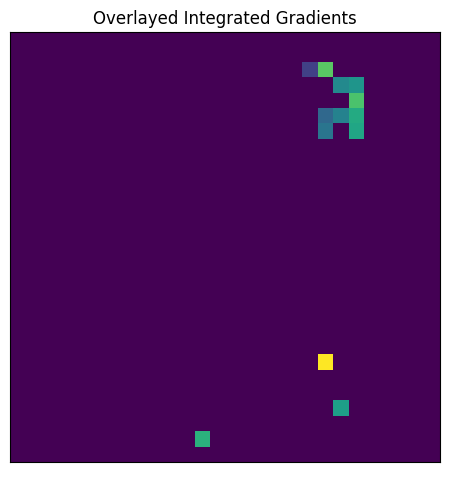

In [62]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.1,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9956755042076111


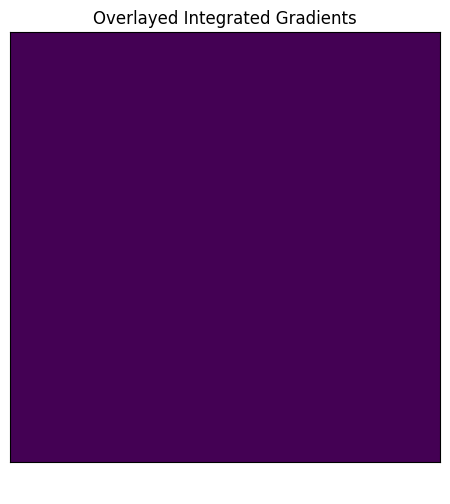

In [63]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.5,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9950793981552124


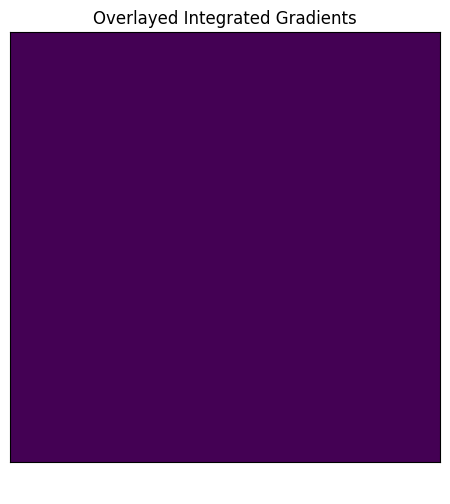

In [64]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.9,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9999667406082153


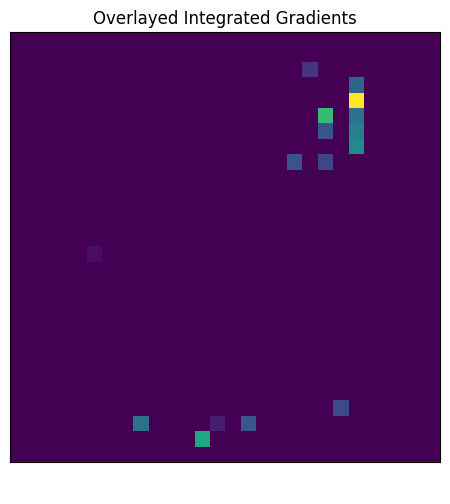

In [65]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=1.0,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Sandal  Probability: 1.0


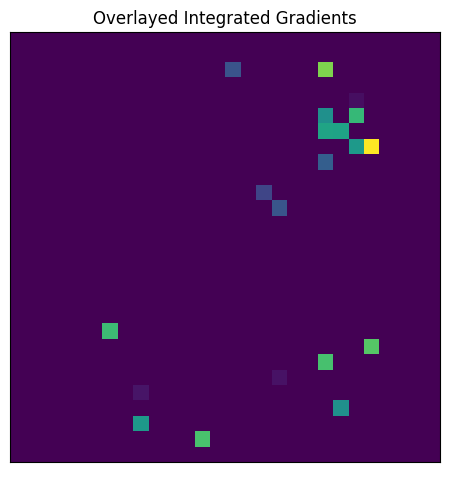

In [66]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=1.5,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Sandal  Probability: 1.0


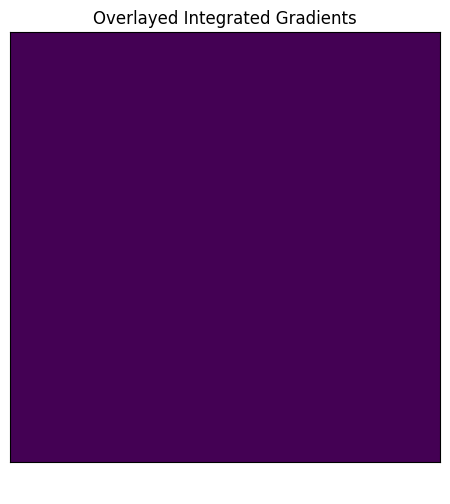

In [67]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=2.0,
                           method='masked_image', sign='positive')